<a href="https://colab.research.google.com/github/SaketMunda/introduction-to-nlp/blob/master/skimlit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Milestone Project : SkimLit 🗒 🔥

In this project, we're going to be putting what we've learned during the `introduction_to_nlp` notebook.

We're going to be replicating the deep learning model behind the 2017 paper [PubMed 200K RCT : a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

RCT : Randomized Controlled Trial abstracts

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

Input : an abstract of a RCT

Output : What role does each sentence serve in the abstract ?

**Problem**:

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution**:

Create an NLP model to classify abstract sentences into the role they play (e.g objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit) and dive deeper when necessary.

**Dataset**:

[PubMed RCT200k from Github](https://github.com/Franck-Dernoncourt/pubmed-rct)


**Replicating Model Architecture**:

[Neural Networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)



In [1]:
# check the gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e91adc92-745f-6fe9-27a9-e9f0e08e0371)


In [2]:
# Import our Helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

from helper_functions import create_tensorboard_callback

--2023-03-08 04:15:03--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-03-08 04:15:04 (50.0 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## Get the Data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.04 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


So we have 4 major directories and each folder contain some txt files, let's check one of it,

In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


- `dev.txt` contains the abstracts for validation set
- `test.txt` is for testing
- `train.txt` is for the training the model

For the baseline and experiment purpose we can start with 20K data in which the numbers are replaces with @ sign, so basically we will use folder `PubMed_20k_RCT_numbers_replaced_with_at_sign`

In [5]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Because our data is in the text files/format, we need to preprocess it first to get ready for the model training and also to get familiar with we need to convert it to something that we will be easy for us to understand.

So let's write a function for it to read the text files,

In [6]:
def get_lines(filename):
  """
  Reads a filename(.txt) and returns the lines of text as a list
  """
  with open(filename,'r') as f:
    return f.readlines()    

In [7]:
# try with training samples
train_lines = get_lines(data_dir+'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

These are the lines of each individual abstracts (which are separated using the `###(_id)` at the start and `\n` in the end) and inside each abstract, there are multiple lines which have labels and texts which are separated with `\t`.

So we need to make this more readable for us and also for the machine. For this we can write a function which will gives us the list of dictionaries in the below format,

```
[{
  'line_number':0,
  'target':'OBJECTIVE',
  'text':'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines':11,
}]
```


In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns the list of dictionaries of abstract line data.

  Takes the filename as input, reads its contents and sorts through each line,
  extracting things like the target label, text of the sentence, how many lines in
  that abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        line_data={}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number 
        line_data['total_lines'] = len(abstract_lines_split) - 1 # total lines, starting from 0
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line
  
  return abstract_samples

In [9]:
# get data from files and preprocess it
%%time

train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 574 ms, sys: 101 ms, total: 675 ms
Wall time: 1.52 s


(180040, 30212, 30135)

Okay now we just created a list of dictionaries for each samples, let's see training samples how it looks

In [10]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

For more visual understanding, let's use `pandas` Dataframe

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.shape

(180040, 4)

In [12]:
train_df.shape, val_df.shape, test_df.shape

((180040, 4), (30212, 4), (30135, 4))

In [13]:
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now our dataframe is ready, we can use data analysis functions of pandas,

In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

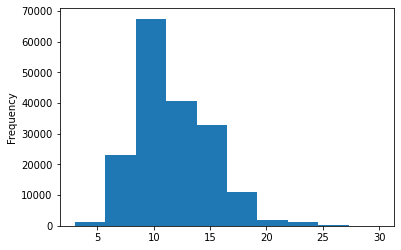

In [15]:
# check the hist distribution of our abstract lenghts
train_df.total_lines.plot.hist();

Looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

### Get lists of sentences

We we build our deep learning models, one of its main inputs will be a list of string (the lines of an abstract).

In [16]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

# check first 10 sentences of training set
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models require numeric labels)

We're going to create label encoded and one hot encoded labels.

Tensorflow CategoriCalCrossEntropy loss function likes to have one hot encoded labels, so we also need one hot encoded labels but for baseline model like Scikit-Learn, label encoded is enough.

### One Hot Encoded

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In the above OneHotEncoder method passing `sparse=False` because if don't then tensorflow will throw an error while converting it into tensors.

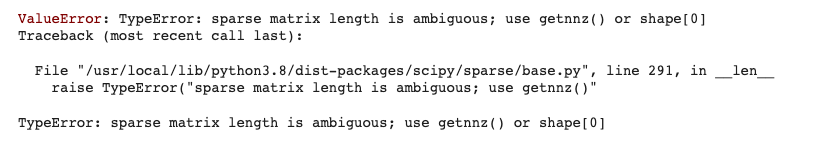

### Label Encoded


In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check the label encoded train labels
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

Let's get the classnames from the trained `LabelEncoder` using `classes_` attribute

In [20]:
# get the class names and number of classes from LabelENcoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)

## Experiment with Various Models

Next we will be going to perform multiple experiments with various models starting from scikit-learn all the way to tensorflow transfer learning.

Modelling experiments will be,
- `model_0` : TFIDF Vectorizer and Multinomial Naive Bayes (baseline)
- `model_1` : Convolutional 1D with token embeddings
- `model_2` : TF Hub Pretrained Feature Extractor
- `model_3` : Conv1D with character embeddings
- `model_4` : Pretrained token embeddings (same as 2) + character embeddings (same as 3)
- `model_5` : Pretrained token embeddings + character embeddings + positional embeddings

### Evaluation Function 

Before starting with multiple modelling experiments we need to create a function for comparison with different metrics, so let's create it

In [21]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def calculate_results(model, tf_model=True, prefetching_used=False, val_dataset=None):
  '''
  Function returns the various metrics results by comparing the 
  y_true and y_pred of a model

  Args:
    - model : Trained model    
    - tf_model(bool) : If tensorflow model then True else False if Scikit-learn model
  
  Returns:
    Dictionary of metrics which are accuracy, precision, recall
    and f1-score    
  '''

  if tf_model:
    if prefetching_used:
      y_true = val_labels_encoded
      # make prediction
      y_pred = model.predict(val_dataset)
      y_pred = y_pred.argmax(axis=1)
    else:
      y_true = val_labels_one_hot.argmax(axis=1)
      # make prediction
      y_pred = model.predict(val_sentences)
      y_pred = y_pred.argmax(axis=1)
  else:
    y_true = val_labels_encoded # for sklearn 
    y_pred = model.predict(val_sentences)  
  

  # measure accuracy
  accuracy = accuracy_score(y_true, y_pred)
  # measure other metrics
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  return {"accuracy": accuracy*100,
          "f1":f1,
          "precision":precision,
          "recall":recall}

### Model_0 : Getting a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# fit the training data to the model
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# evaluate the model using validation sentences
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [24]:
# make some prediction
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [26]:
# calculate results of baseline model
baseline_results = calculate_results(model_0, tf_model=False)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for Deep Learning Models

We need to create text vectorization and embedding layers for deep learning models.

The vectorization layer convert the text into numbers and embedding layer will capture the relationship betwen those numbers.

In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is 8 words long and another is 29 words long then we want to pad the 8 word sentences with zeros so it ends up being the same length as the 29 word sentence.

In [28]:
# How long each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
average_len = np.mean(sent_lens)
average_len

26.338269273494777

How about the distribution of sentence lengths ?

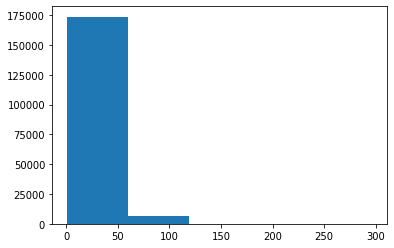

In [29]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=5);

Looks like majority of sentences are between 0 and 50 tokens in length.

We can use Numpy's `percentile` to find the value which covers 95% of the sentence lengths.

In [30]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Checking the maximum sentence length,

In [31]:
max(sent_lens)

296

### Create Text Vectorizer

For converting text into numbers we'll use `TextVectorization` layer from tensorflow.

We'll keep the default parameters except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200K RCT Paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

In [32]:
max_tokens = 68000

In [33]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                           output_sequence_length=output_seq_len)

In [34]:
# now need to adapt with training sample
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out the text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text:{len(target_sentence.split())}')
print(f'\nVectorized Text:\n{text_vectorizer([target_sentence])}')

Text:
a @-day antibiotic regimen of oral ciprofloxacin and metronidazole is as effective as a @-day regimenin the prevention of infective complications following transrectalprostate biopsy .

Length of text:25

Vectorized Text:
[[    8   108  1274   576     4   217 11699     3  4883    20    25   137
     25     8   108 47009     2   403     4 15880   296   240 43354  1220
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Get more information from our `text_vectorizer` inside the `train_sentences`

In [36]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Numbers of vocabulary in train_sentences: {len(rct_20k_text_vocab)}")
print(f'Most common words in the vocabulary: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}')

Numbers of vocabulary in train_sentences: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# get the config of our text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create Custom Embedding

Now after creating the vectorization layer, we want to create embedding layer using Tensorflow's `Embedding` layer.

In [38]:
# create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,
                               #mask_zero=True, # use masking to handle variable sequence length contains zeros
                               name="token_embedding")

# Show example embedding
print(f"Sentence before embedding:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n{vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before embedding:
a @-day antibiotic regimen of oral ciprofloxacin and metronidazole is as effective as a @-day regimenin the prevention of infective complications following transrectalprostate biopsy .
Sentence after vectorization:
[[    8   108  1274   576     4   217 11699     3  4883    20    25   137
     25     8   108 47009     2   403     4 15880   296   240 43354  1220
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
[[[-0.02558423  0.03257177 -0.01878533 ...  0.03826909  0.01442715
   -0.04268723]
  [-0.00936756 -0.04977662  0.01859546 ...  0.04753859 -0.03843747
    0.00478116]
  [-0.03503411 -0.02659943 -0.00258841 ... -0.00191174 -0.0042525
    0.02603542]
  ...
  [ 0.04756131 -0.04023252 -0.00901216 ...  0.03599645 -0.04280417
    0.01265134]
  [ 0.04756131 -0.04023252 -0.00901216 ...  0.0359964

### Creating datasets (make sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed in the below guides,

- https://www.tensorflow.org/guide/data_performance
- https://www.tensorflow.org/guide/data


In [39]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSlicedDataset and turn them into prefetched batch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [41]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

So I guess now we are ready to build `model_1` i.e Conv1D with Token Embedding

## Model_1 : Conv1D with Token Embedding

In [42]:
SAVE_DIR = 'model_logs'

### model without prefetching

In [43]:
# create the model using Sequential API (without using prefetch)
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    token_embed,   
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(num_classes, activation='softmax')
], name='conv1d_with_token_embedding')

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(np.array(train_sentences),
                        train_labels_one_hot,
                        epochs=5,
                        validation_data=(np.array(val_sentences), val_labels_one_hot),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='conv1d_with_token_embeddings')])

Saving Tensorboard log files to: model_logs/conv1d_with_token_embeddings/20230308-041618
Epoch 1/5
5627/5627 [==============================] - 118s 19ms/step - loss: 0.5535 - accuracy: 0.7964 - val_loss: 0.4831 - val_accuracy: 0.8218
Epoch 2/5
5627/5627 [==============================] - 60s 11ms/step - loss: 0.3596 - accuracy: 0.8718 - val_loss: 0.5126 - val_accuracy: 0.8149
Epoch 3/5
5627/5627 [==============================] - 65s 11ms/step - loss: 0.2135 - accuracy: 0.9298 - val_loss: 0.5827 - val_accuracy: 0.8091
Epoch 4/5
5627/5627 [==============================] - 47s 8ms/step - loss: 0.1099 - accuracy: 0.9666 - val_loss: 0.7160 - val_accuracy: 0.7995
Epoch 5/5
5627/5627 [==============================] - 59s 10ms/step - loss: 0.0584 - accuracy: 0.9831 - val_loss: 0.8627 - val_accuracy: 0.7940


In [44]:
model_1.summary()

Model: "conv1d_with_token_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,340,997
Trainable param

In [45]:
# view results
model_1_results = calculate_results(model_1)
model_1_results

945/945 [==============================] - 5s 5ms/step


{'accuracy': 79.40222428174235,
 'f1': 0.7934856505522715,
 'precision': 0.7933068239918648,
 'recall': 0.7940222428174235}

### model with prefetching

In [46]:
token_embed_1 = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

# creating model using Functional API
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed_1(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1_1 = tf.keras.Model(inputs, outputs, name='conv1D_with_token_embedding')


# compile the model
model_1_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# summary of the model
model_1_1.summary()

Model: "conv1D_with_token_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 5) 

In [47]:
# fit the model
history_1_1 = model_1_1.fit(train_dataset,
                            steps_per_epoch=int(0.1 * len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1 * len(valid_dataset)),
                            callbacks=[create_tensorboard_callback(SAVE_DIR, "conv1D_with_token_embeddings_prefetch")])

Saving Tensorboard log files to: model_logs/conv1D_with_token_embeddings_prefetch/20230308-042248
Epoch 1/3
562/562 [==============================] - 24s 40ms/step - loss: 0.9223 - accuracy: 0.6374 - val_loss: 0.6853 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6527 - accuracy: 0.7584 - val_loss: 0.6303 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6127 - accuracy: 0.7757 - val_loss: 0.5938 - val_accuracy: 0.7866


In [48]:
# Make prediction
model_1_1_pred_probs = model_1_1.predict(valid_dataset)
model_1_1_preds = model_1_1_pred_probs.argmax(axis=1)
model_1_1_preds

945/945 [==============================] - 2s 2ms/step


array([0, 0, 3, ..., 4, 1, 1])

In [49]:
# calculate results
model_1_1_results = calculate_results(model_1_1, prefetching_used=True, val_dataset=valid_dataset)
model_1_1_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 78.8560836753608,
 'f1': 0.7863097361066143,
 'precision': 0.7856749863676958,
 'recall': 0.7885608367536079}

## Model_2 : TensorFlow Hub Pretrained Feature Extractor

First, we would need a feature extractor embedding layer to transform text into numbers, so we are using Universal Sentence Encoder as a feature extraction embedding layer https://tfhub.dev/google/universal-sentence-encoder/4.

Then we can build the model and compile.

In [50]:
import tensorflow_hub as hub

use_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name='use_embedding_layer')
random_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n{random_sentence}")
use_embedded = use_embedding_layer([random_sentence])
print(f"Sentence after Embedding:\n{use_embedded}")
print(f"Length of Embedding:\n{len(use_embedded[0])}")

Random Sentence:
ondansetrone is believed to be more reliable agent than metoclopramide when used with mivacurium .
Sentence after Embedding:
[[-0.01112025 -0.00616183 -0.01910535 -0.01196342 -0.00559546  0.04449072
   0.04751996 -0.08424371  0.0601467   0.02296652  0.02488031  0.00982544
  -0.00258122 -0.02021801  0.03207814 -0.015805    0.05680793 -0.0219287
   0.02638036  0.07688747  0.04860816 -0.04694863 -0.05997981 -0.03719705
   0.07361884  0.01949852 -0.03652497 -0.01142965  0.00019885 -0.00215625
  -0.05598839 -0.01318798 -0.0720252   0.0348883  -0.03455585 -0.0543695
  -0.04218865 -0.05881535  0.00900961  0.01900303  0.02586853 -0.03031651
   0.08628123  0.01572537 -0.04100651  0.02177223  0.00279711  0.03825638
   0.01214645  0.04771207  0.03044163 -0.05524098  0.09248377 -0.06147088
  -0.05464523  0.01053124 -0.08936495 -0.04072406  0.03300691  0.00197693
  -0.06227347  0.03264912 -0.01740522 -0.01553322  0.00629764 -0.05643559
   0.01201596 -0.01061582  0.00219596 -0.00496

Outputs of USE Embedding layer is 512 dimensional embedding vector.

### Building and Fitting an NLP Feature Extractor model using TensorFlow Hub

In [51]:
# define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = use_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# fit the model
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1 * len(valid_dataset)),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "use_feature_extractor_model")])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Saving Tensorboard log files to: model_logs/use_feature_extractor_model/20230308-042401
Epoch 1/3
562/562 [==============================] - 19s 24ms/step - loss: 0.9157 - accuracy: 0.6510 - val_loss: 0.7949 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7690 - accuracy: 0.7012 - val_loss: 0.7557 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 14s 26ms/step - loss: 0.7531 - accuracy: 0.7125 - val_loss: 0.7385 - val_accuracy: 0.7144


**Note:** Training is a lot quicker because we haven't set the parameter `trainable=True` while feature extraction.

In [52]:
# see the summary
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 use_embedding_layer (KerasL  (None, 512)              256797824 
 ayer)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [53]:
# evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7413 - accuracy: 0.7145


[0.7413012385368347, 0.7144843339920044]

In [54]:
# calculate results
model_2_results = calculate_results(model_2, prefetching_used=True, val_dataset=valid_dataset)
model_2_results

945/945 [==============================] - 20s 20ms/step


{'accuracy': 71.44843108698531,
 'f1': 0.7115587434802126,
 'precision': 0.7148956385024102,
 'recall': 0.7144843108698531}

## Model_3 : Conv1D with Character Embeddings

**What is Character Embedding ?**

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g `tensorflow` -> [`t`,`e`,`n`,`s`,`o`,`r`,`f`,`l`,`o`,`w`]) where as a **token embedding** is created on sequences split into tokens(words).

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an `Embedding` layer.

### Create a Character Level Tokenizer

In [55]:
# we need to first split the sentences into chars
def split_chars(text):
  return " ".join(list(text))


# test splitting non-character level sequence into characters
split_chars(random_sentence)

'o n d a n s e t r o n e   i s   b e l i e v e d   t o   b e   m o r e   r e l i a b l e   a g e n t   t h a n   m e t o c l o p r a m i d e   w h e n   u s e d   w i t h   m i v a c u r i u m   .'

In [56]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [57]:
# now we need to find the maximum character length in each sentences
char_len = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_len)
mean_char_length

149.3662574983337

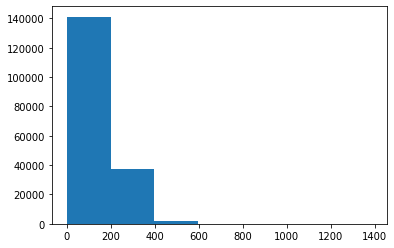

In [58]:
# check the distribution
plt.hist(char_len, bins=7);

Looks like most of our sequences are between 0 and 200 characters long.

Let's use NumPy percentile to figure out what length covers 95% of our sequences.

In [59]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

We can use `output_seq_char_len` for `output_sequence_length` in `TextVectorization` layer

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocab or unknown) tokens.

In [60]:
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [61]:
NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", # default setting
                                    name='char_vectorizer') 

# adapt the vectorizer
char_vectorizer.adapt(train_chars)

In [62]:
# check the vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in the character vocab:{len(char_vocab)}')
print(f'5 Most common characters:{char_vocab[:5]}')
print(f'5 Least common characters:{char_vocab[-5:]}')

Number of different characters in the character vocab:28
5 Most common characters:['', '[UNK]', 'e', 't', 'i']
5 Least common characters:['k', 'x', 'z', 'q', 'j']


Test on random sentence

In [63]:
random_train_chars = random.choice(train_chars)
print(f'Charified Text:\n {random_train_chars}')
print(f'\n Length of chars:{len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\n Vectorized Chars:\n{vectorized_chars}')
print(f'\n Length of vectorized chars:{len(vectorized_chars[0])}')

Charified Text:
 w e   c o n d u c t e d   a   p r o s p e c t i v e   ,   r a n d o m i z e d   ,   d o u b l e - b l i n d   s t u d y   a t   @   s i t e s   i n   @   c o u n t r i e s   .

 Length of chars:73

 Vectorized Chars:
[[20  2 11  7  6 10 16 11  3  2 10  5 14  8  7  9 14  2 11  3  4 21  2  8
   5  6 10  7 15  4 25  2 10 10  7 16 22 12  2 22 12  4  6 10  9  3 16 10
  19  5  3  9  4  3  2  9  4  6 11  7 16  6  3  8  4  2  9  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

### Create character-level embedding

Just like character-level tokenizer, we can create character-level embedding using `tensorflow.keras.layers.Embedding` and setting `input_dim` as the length of different character length i.e `char_vocab` and `output_dim` as 25, mentioned in the paper (Fig 1 https://arxiv.org/pdf/1612.05251.pdf)

In [64]:
# create char level embedding
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero = False, # this time setting as False
                              name='char_embedding')

# test our embedding
print(f'Charified Text (before vectorization and embedding):\n{random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded Chars:\n{char_embed_example}')
print(f'Character Embedding Shape:{char_embed_example.shape}')

Charified Text (before vectorization and embedding):
w e   c o n d u c t e d   a   p r o s p e c t i v e   ,   r a n d o m i z e d   ,   d o u b l e - b l i n d   s t u d y   a t   @   s i t e s   i n   @   c o u n t r i e s   .
Embedded Chars:
[[[ 0.00706972  0.01015954 -0.04930619 ... -0.00880323 -0.01124422
    0.00535055]
  [ 0.0460924  -0.01188881 -0.04551504 ...  0.02148407 -0.01016424
    0.01832933]
  [-0.01051811 -0.01192007 -0.02291792 ...  0.01694546  0.02279954
    0.02164901]
  ...
  [-0.04177426 -0.01506365 -0.00190999 ...  0.02117021 -0.04884288
   -0.0268286 ]
  [-0.04177426 -0.01506365 -0.00190999 ...  0.02117021 -0.04884288
   -0.0268286 ]
  [-0.04177426 -0.01506365 -0.00190999 ...  0.02117021 -0.04884288
   -0.0268286 ]]]
Character Embedding Shape:(1, 290, 25)


### Create Char Level datasets

Same like train_dataset which is created using train_sentences we need to create prefetch dataset for character level data

In [66]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building, fitting and evaluating a Conv1D model on character embeddings

In [69]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_with_character_embeddings')

# compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# fit the model
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1 * len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1 * len(val_char_dataset)),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "conv1D_with_character_embeddings")])

Saving Tensorboard log files to: model_logs/conv1D_with_character_embeddings/20230308-043522
Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2625 - accuracy: 0.4801 - val_loss: 1.1372 - val_accuracy: 0.5472
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0983 - accuracy: 0.5507 - val_loss: 1.0293 - val_accuracy: 0.5848
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0058 - accuracy: 0.5979 - val_loss: 0.9555 - val_accuracy: 0.6300


In [70]:
# evaluate
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.9766 - accuracy: 0.6147


[0.9766135215759277, 0.6146564483642578]

In [72]:
# calculate results
model_3_results = calculate_results(model=model_3,
                                    prefetching_used=True,
                                    val_dataset=val_char_dataset)

model_3_results

945/945 [==============================] - 4s 4ms/step


{'accuracy': 61.465642790943996,
 'f1': 0.6058633270821686,
 'precision': 0.6234891336504191,
 'recall': 0.61465642790944}